<a href="https://colab.research.google.com/github/NightPrinceY/CollegeForFun/blob/main/TEMPERATURE_FORCAST_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [7]:
TEMPERATURES_CSV = '/content/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [8]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [9]:
def parse_data_from_file(filename):

    times = []
    temperatures = []


    with open(filename) as csvfile:

        reader = csv.reader(csvfile, delimiter=',')
        next(reader)  # Skip the header row
        for row in reader:
            times.append(row[0])
            temperatures.append(float(row[1]))


    return times, temperatures

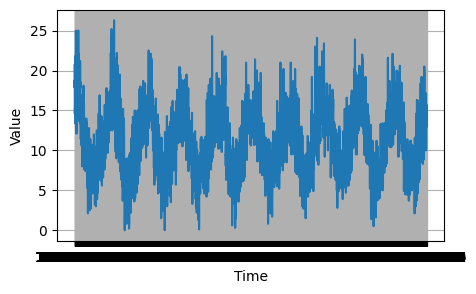

In [10]:
@dataclass
class G:
    TEMPERATURES_CSV = '/content/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(5,3))
plot_series(G.TIME, G.SERIES)
plt.show()

In [11]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [12]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds




In [13]:
train_set = windowed_dataset(series_train,
                             window_size=G.WINDOW_SIZE,
                             batch_size=G.BATCH_SIZE,
                             shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [14]:
def create_uncompiled_model():


    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, 3, padding='causal', activation='relu', input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    return model

In [15]:

uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):

    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)

# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
1/1 [==============================] - 2s 2s/step
Your current architecture is compatible with the windowed dataset! :)


In [16]:
def create_model():

    model = create_uncompiled_model()

    model.compile(loss='huber',
                  optimizer='adam',
                  metrics=["mae"])
    return model

In [17]:
model = create_model()

history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 9s 16ms/step - loss: 5.4834 - mae: 5.9643
Epoch 2/50
77/77 [==============================] - 1s 15ms/step - loss: 2.6971 - mae: 3.1615
Epoch 3/50
77/77 [==============================] - 2s 26ms/step - loss: 2.1169 - mae: 2.5720
Epoch 4/50
77/77 [==============================] - 1s 15ms/step - loss: 1.7185 - mae: 2.1686
Epoch 5/50
77/77 [==============================] - 1s 15ms/step - loss: 1.5825 - mae: 2.0280
Epoch 6/50
77/77 [==============================] - 1s 15ms/step - loss: 1.5303 - mae: 1.9731
Epoch 7/50
77/77 [==============================] - 1s 15ms/step - loss: 1.5260 - mae: 1.9682
Epoch 8/50
77/77 [==============================] - 1s 15ms/step - loss: 1.5170 - mae: 1.9622
Epoch 9/50
77/77 [==============================] - 1s 15ms/step - loss: 1.5068 - mae: 1.9454
Epoch 10/50
77/77 [==============================] - 2s 21ms/step - loss: 1.5114 - mae: 1.9532
Epoch 11/50
77/77 [==============================] - 1s 15m

In [18]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [19]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

113/113 [==============================] - 2s 8ms/step


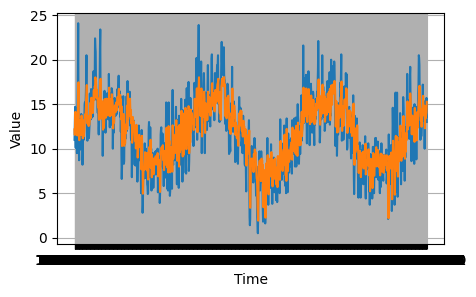

In [20]:
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(5, 3))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [21]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.12, mae: 1.77 for forecast


In [22]:
def predict_temperature(model, series, window_size, date):
    # Prepare the input data for prediction
    input_data = series[-window_size:]  # Use the most recent window of data
    input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension
    # Generate prediction
    forecast = model.predict(input_data).flatten()
    # Return the forecasted temperature for the given date
    return forecast[0]



In [23]:
# Example usage:
date_to_predict = '2024-03-05'  # Date to predict temperature for
forecasted_temperature = predict_temperature(model, G.SERIES, G.WINDOW_SIZE, date_to_predict)
print(f"The forecasted temperature for {date_to_predict} is {forecasted_temperature:.2f} degrees Celsius.")


1/1 [==============================] - 1s 1s/step
The forecasted temperature for 2024-03-05 is 13.43 degrees Celsius.
